# Цель проекта - определение виновности в ДТП

In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

from sklearn import mixture
from sklearn import manifold
from sklearn import pipeline
from sklearn import preprocessing
from sklearn import cluster
from sklearn import metrics
from sklearn import model_selection
from sklearn import decomposition
from sklearn import ensemble
from sklearn import linear_model
from sklearn import metrics
import hyperopt
from hyperopt import hp, fmin, tpe, Trials
from catboost import CatBoostClassifier, Pool
import warnings 

from IPython.display import display, HTML

warnings.filterwarnings("ignore")

plt.rcParams["patch.force_edgecolor"] = True

In [2]:
data = pd.read_csv("data/data_diplom.csv", encoding='windows-1251', sep=';')
data.rename(columns={'Accident_Flag':'Flag_Guilty'}, inplace = True)
print(f'Data shape: {data.shape}')
data.head(5)

Data shape: (500000, 22)


,RAMI_Report_ID,RAMI_Owner_ID,Agreement_CreateDate,Agreement_BeginDate,Agreement_EndDate,Ownership_BeginDate,Owner_Birthday,Vehicle_Brand,Vehicle_Model,Vehicle_Category,...,ReleaseYear,First_Registration_Year,Vehicle_Region_ID,Transit_Flag,WP,Allowed_Count,KBM_ID,Region_Change_Count,Amount_Accidents,Flag_Guilty
0,146142370,33905930,2021-03-11,2021-03-20,2022-03-19,2020-03-20,1987-04-25,lexus,LX,B,...,2015,2016,54,0,"9562,2399999999998",2,11,1,0,0
1,177251055,24158446,2021-10-22,2021-10-25,2022-10-24,2017-10-25,1963-03-07,УАЗ,3303,B,...,2011,2011,52,0,"3336,6199999999999",1,13,0,0,0
2,288836179,922693,2022-10-14,2022-11-01,2023-10-31,2014-11-20,1971-12-04,kIA,SORENTO,B,...,2009,2010,77,0,"11617,01",1,8,0,0,0
3,13515640,66946100,2021-05-12,2021-05-13,2022-05-12,2020-02-04,1994-12-28,HONDA,FIT,B,...,2002,2002,79,0,"3415,5500000000002",1,8,1,0,0
4,57705831,13625025,2020-06-15,2020-06-18,2021-06-17,2015-06-17,1986-11-26,VOLKSWAGEN,PASSAT,B,...,1994,1994,58,0,"9956,2099999999991",3,7,1,0,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 22 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   RAMI_Report_ID           500000 non-null  int64 
 1   RAMI_Owner_ID            500000 non-null  int64 
 2   Agreement_CreateDate     500000 non-null  object
 3   Agreement_BeginDate      500000 non-null  object
 4   Agreement_EndDate        500000 non-null  object
 5   Ownership_BeginDate      500000 non-null  object
 6   Owner_Birthday           500000 non-null  object
 7   Vehicle_Brand            500000 non-null  object
 8   Vehicle_Model            499998 non-null  object
 9   Vehicle_Category         500000 non-null  object
 10  Vehicle_EngineHPower     500000 non-null  object
 11  Vehicle_Usage            499997 non-null  object
 12  ReleaseYear              500000 non-null  int64 
 13  First_Registration_Year  500000 non-null  int64 
 14  Vehicle_Region_ID   

### Преобразуем данные:
* даты в формат дат
* мощность ТС
* страховую премию полиса
* категория ТС

In [4]:
data['Agreement_CreateDate'] = pd.to_datetime(data['Agreement_CreateDate'])
data['Agreement_BeginDate'] = pd.to_datetime(data['Agreement_BeginDate'])
data['Agreement_EndDate'] = pd.to_datetime(data['Agreement_EndDate'])
data['Ownership_BeginDate'] = pd.to_datetime(data['Ownership_BeginDate'])
data['Owner_Birthday'] = pd.to_datetime(data['Owner_Birthday'])
data['Vehicle_EngineHPower'] = pd.to_numeric(data['Vehicle_EngineHPower'].apply(lambda x: x.replace(',', '.')), downcast='float')
data['Vehicle_Category'] = data['Vehicle_Category'].apply(lambda x: 'C' if x == 'с' else x)
data['WP'] = pd.to_numeric(data['WP'].apply(lambda x: x.replace(',', '.')), downcast='float')

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 22 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   RAMI_Report_ID           500000 non-null  int64         
 1   RAMI_Owner_ID            500000 non-null  int64         
 2   Agreement_CreateDate     500000 non-null  datetime64[ns]
 3   Agreement_BeginDate      500000 non-null  datetime64[ns]
 4   Agreement_EndDate        500000 non-null  datetime64[ns]
 5   Ownership_BeginDate      500000 non-null  datetime64[ns]
 6   Owner_Birthday           500000 non-null  datetime64[ns]
 7   Vehicle_Brand            500000 non-null  object        
 8   Vehicle_Model            499998 non-null  object        
 9   Vehicle_Category         500000 non-null  object        
 10  Vehicle_EngineHPower     500000 non-null  float32       
 11  Vehicle_Usage            499997 non-null  object        
 12  ReleaseYear     

### Добавим новые показатели:
* возраст владельца ТС
* возраст ТС
* период владения ТС данным собственником
* срок эксплуатации данного ТС с момента первой регистрации ТС до даты начала владения данным собственником
* срок действия полиса

In [5]:
data['Owner_Age'] = round((data['Agreement_CreateDate'] - data['Owner_Birthday']).dt.days/365.25, 1)
data['Vehicle_Age'] = data['Agreement_CreateDate'].dt.year - data['ReleaseYear']
data['Period_Ownership'] = round((data['Agreement_CreateDate'] - data['Ownership_BeginDate']).dt.days/365.25, 1)
data['Period_of_Use'] = data['Ownership_BeginDate'].dt.year - data['First_Registration_Year']
data['Period_of_Policy'] = round((data['Agreement_EndDate'] - data['Agreement_BeginDate']).dt.days/365.25, 1)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 27 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   RAMI_Report_ID           500000 non-null  int64         
 1   RAMI_Owner_ID            500000 non-null  int64         
 2   Agreement_CreateDate     500000 non-null  datetime64[ns]
 3   Agreement_BeginDate      500000 non-null  datetime64[ns]
 4   Agreement_EndDate        500000 non-null  datetime64[ns]
 5   Ownership_BeginDate      500000 non-null  datetime64[ns]
 6   Owner_Birthday           500000 non-null  datetime64[ns]
 7   Vehicle_Brand            500000 non-null  object        
 8   Vehicle_Model            499998 non-null  object        
 9   Vehicle_Category         500000 non-null  object        
 10  Vehicle_EngineHPower     500000 non-null  float32       
 11  Vehicle_Usage            499997 non-null  object        
 12  ReleaseYear     

#### Посмотрим на данные с пропусками - Vehicle_Model и Vehicle_Usage

In [6]:
data[data['Vehicle_Model'].isnull() | data['Vehicle_Usage'].isnull()][['Vehicle_Brand', 'Vehicle_Model', 
                                                                       'Vehicle_Usage', 'Flag_Guilty']]

,Vehicle_Brand,Vehicle_Model,Vehicle_Usage,Flag_Guilty
226730,gaz,172401,NaN,0
262747,2824,NaN,Личная,0
342686,BMW,X5,NaN,1
491170,2824,NaN,Личная,0
491739,ВАЗ/LADa,2170/Priora,NaN,1


> Видно, что модель ТС отсутствует у неизвестных марок (указано просто число) - такие записи можно будет удалить.
> А вот тип использования отсутствует у BMW X5, Лады Приоры и Газели, причем у первых двух присутствует целевой показатель, поэтому тип использования у них лучше заменить на "Личная".

#### Делаем замену для Vehicle_Usage и удаляем столбцы RAMI_Report_ID, RAMI_Owner_ID и строки с пропусками в Vehicle_Model

In [7]:
data['Vehicle_Usage'].fillna('Личная', inplace=True)
data = data[data['Vehicle_Model'].isnull() == False].drop(['RAMI_Report_ID', 'RAMI_Owner_ID'], axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 499998 entries, 0 to 499999
Data columns (total 25 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   Agreement_CreateDate     499998 non-null  datetime64[ns]
 1   Agreement_BeginDate      499998 non-null  datetime64[ns]
 2   Agreement_EndDate        499998 non-null  datetime64[ns]
 3   Ownership_BeginDate      499998 non-null  datetime64[ns]
 4   Owner_Birthday           499998 non-null  datetime64[ns]
 5   Vehicle_Brand            499998 non-null  object        
 6   Vehicle_Model            499998 non-null  object        
 7   Vehicle_Category         499998 non-null  object        
 8   Vehicle_EngineHPower     499998 non-null  float32       
 9   Vehicle_Usage            499998 non-null  object        
 10  ReleaseYear              499998 non-null  int64         
 11  First_Registration_Year  499998 non-null  int64         
 12  Vehicle_Region_I

In [8]:
data.isnull().sum()

Agreement_CreateDate       0
Agreement_BeginDate        0
Agreement_EndDate          0
Ownership_BeginDate        0
Owner_Birthday             0
Vehicle_Brand              0
Vehicle_Model              0
Vehicle_Category           0
Vehicle_EngineHPower       0
Vehicle_Usage              0
ReleaseYear                0
First_Registration_Year    0
Vehicle_Region_ID          0
Transit_Flag               0
WP                         0
Allowed_Count              0
KBM_ID                     0
Region_Change_Count        0
Amount_Accidents           0
Flag_Guilty                0
Owner_Age                  0
Vehicle_Age                0
Period_Ownership           0
Period_of_Use              0
Period_of_Policy           0
dtype: int64

#### Проверим данные на полностью дублирующиеся записи

In [9]:
print(f'В таблице полностью дублирующихся записей = {data.duplicated().sum()}')

В таблице полностью дублирующихся записей = 0


#### Осталось проверить последние текстовые показатели - Vehicle_Brand, Vehicle_Model, Vehicle_Category, Vehicle_Usage

In [10]:
print(f'Кол-во категорий ТС = {data.Vehicle_Category.nunique()}')

data['Vehicle_Brand'] = data['Vehicle_Brand'].apply(lambda x: x.upper())
print(f'Кол-во уникальных марок ТС = {data.Vehicle_Brand.nunique()}')

data['Vehicle_Model'] = data['Vehicle_Model'].apply(lambda x: x.upper())
print(f'Кол-во уникальных моделей ТС = {data.Vehicle_Model.nunique()}')

data['Vehicle_Usage'] = data['Vehicle_Usage'].apply(lambda x: x.upper())
print(f'Кол-во типов использования ТС = {data.Vehicle_Usage.nunique()}')

Кол-во категорий ТС = 7
Кол-во уникальных марок ТС = 1583
Кол-во уникальных моделей ТС = 10032
Кол-во типов использования ТС = 11


> Видим, что марок ТС у нас больше 1500, а моделей больше 10000. Поэтому столбец Vehicle_Model удалим, а с Vehicle_Category, Vehicle_Brand и Vehicle_Usage проведем несколько действий.

In [11]:
brands = ['AUDI', 'BMW', 'CHERY', 'CHEVROLET', 'CITROEN', 'DAEWOO', 'DATSUN', 'FIAT', 'FORD ', 'GEELY', 'GREAT WALL', 'HONDA',
          'HYUNDAI', 'INFINITI', 'KIA', 'LAND ROVER', 'LEXUS', 'LIFAN', 'MAZDA', 'MERCEDES-BENZ', 'MITSUBISHI', 'NISSAN', 'OPEL',
          'PEUGEOT', 'RENAULT', 'SKODA', 'SSANGYONG', 'SUBARU', 'SUZUKI', 'TOYOTA', 'VOLKSWAGEN', 'VOLVO', 'ВАЗ/LADA', 'ГАЗ',
          'ПРОЧИЕ', 'УАЗ']

usage = ['ЛИЧНАЯ', 'ТАКСИ', 'ПРОЧЕЕ', 'УЧЕБНАЯ ЕЗДА', 'РЕГУЛЯРНЫЕ ПЕРЕВОЗКИ', 'ПРОКАТ/КРАТКОСРОЧНАЯ АРЕНДА',
        'ДОРОЖНЫЕ И СПЕЦИАЛЬНЫЕ ТС', 'ЭКСТРЕННЫЕ И КОММУНАЛЬНЫЕ СЛУЖБЫ', 'ПЕРЕВОЗКА ОПАСНЫХ И ЛЕГКОВОСПЛАМЕНЯЮЩИХСЯ ГРУЗОВ']

category = ['A', 'B', 'C', 'D', 'F']

def brand_rename(x):
    if x in brands:
        return x
    elif x in ['LADA', 'ВАЗ']:
        return 'ВАЗ/LADA'
    else:
        return 'ПРОЧИЕ'

def category_rename(x):
    if x in category:
        return x
    else:
        return 'B'    
    
def usage_rename(x):
    if x in usage:
        return x
    elif x=='ПЕРЕВОЗКА ОПАСНЫХ И ЛЕГКО ВОСПЛАМЕНЯЮЩИХСЯ ГРУЗОВ':
        return 'ПЕРЕВОЗКА ОПАСНЫХ И ЛЕГКОВОСПЛАМЕНЯЮЩИХСЯ ГРУЗОВ'
    else:
        return 'ПРОКАТ/КРАТКОСРОЧНАЯ АРЕНДА'    
    
data['Vehicle_Brand'] = data['Vehicle_Brand'].apply(brand_rename)
data['Vehicle_Usage'] = data['Vehicle_Usage'].apply(usage_rename)
data['Vehicle_Category'] = data['Vehicle_Category'].apply(category_rename)

#### Удаляем ненужные нам показатели

In [12]:
data = data.drop(['Agreement_CreateDate', 'Agreement_BeginDate', 'Agreement_EndDate', 'Ownership_BeginDate',
                  'Owner_Birthday', 'Vehicle_Model', 'ReleaseYear', 'First_Registration_Year'], axis=1)

data.reset_index(drop=True, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499998 entries, 0 to 499997
Data columns (total 17 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Vehicle_Brand         499998 non-null  object 
 1   Vehicle_Category      499998 non-null  object 
 2   Vehicle_EngineHPower  499998 non-null  float32
 3   Vehicle_Usage         499998 non-null  object 
 4   Vehicle_Region_ID     499998 non-null  int64  
 5   Transit_Flag          499998 non-null  int64  
 6   WP                    499998 non-null  float32
 7   Allowed_Count         499998 non-null  int64  
 8   KBM_ID                499998 non-null  int64  
 9   Region_Change_Count   499998 non-null  int64  
 10  Amount_Accidents      499998 non-null  int64  
 11  Flag_Guilty           499998 non-null  int64  
 12  Owner_Age             499998 non-null  float64
 13  Vehicle_Age           499998 non-null  int64  
 14  Period_Ownership      499998 non-null  float64
 15  

#### Посмотрим описательную статистику показателей

In [13]:
data.describe()

,Vehicle_EngineHPower,Vehicle_Region_ID,Transit_Flag,WP,Allowed_Count,KBM_ID,Region_Change_Count,Amount_Accidents,Flag_Guilty,Owner_Age,Vehicle_Age,Period_Ownership,Period_of_Use,Period_of_Policy
count,499998.000000,499998.000000,499998.000000,499998.000000,499998.000000,499998.000000,499998.000000,499998.000000,499998.000000,499998.000000,499998.000000,499998.000000,499998.000000,499998.000000
mean,122.593819,48.258877,0.003502,5975.098633,1.736011,10.269065,0.354039,0.043872,0.039758,46.854869,11.128131,4.347739,6.583730,0.996526
std,58.446873,23.290764,0.059074,3984.895996,0.936171,3.442887,0.705517,0.228533,0.195391,13.651315,7.509765,4.185210,7.010623,0.056015
min,0.000000,1.000000,0.000000,-3362.449951,0.000000,1.000000,0.000000,0.000000,0.000000,-0.900000,-1.000000,-1.700000,0.000000,0.000000
25%,87.000000,27.000000,0.000000,3541.837585,1.000000,7.000000,0.000000,0.000000,0.000000,36.100000,6.000000,1.000000,0.000000,1.000000
50%,110.000000,50.000000,0.000000,5008.919922,2.000000,10.000000,0.000000,0.000000,0.000000,45.400000,10.000000,3.000000,5.000000,1.000000
75%,143.000000,68.000000,0.000000,7191.819824,2.000000,14.000000,1.000000,0.000000,0.000000,57.700000,15.000000,7.000000,11.000000,1.000000
max,13596.000000,94.000000,1.000000,145448.062500,39.000000,15.000000,44.000000,7.000000,1.000000,120.400000,2022.000000,72.700000,121.000000,1.000000


#### Построим коробчатые диаграммы для каждого из признаков:

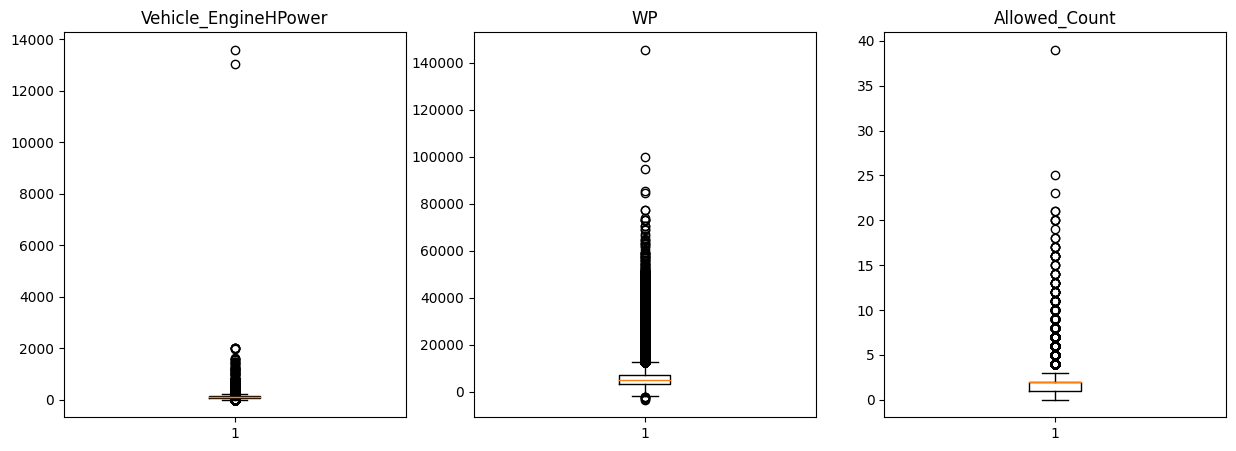

In [14]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.boxplot(data['Vehicle_EngineHPower'])
plt.title("Vehicle_EngineHPower")

plt.subplot(1, 3, 2)
plt.boxplot(data['WP'])
plt.title("WP")

plt.subplot(1, 3, 3)
plt.boxplot(data['Allowed_Count'])
plt.title("Allowed_Count");

> Видно, что у нас есть ТС с мощностью двигателя равные как нулю, так и больше 13000.

> Стоимость полиса может быть как отрицательная, нулевая, так и больше 145000.

> Кол-во допущенных лиц колеблется от нуля (что означает без ограничений) до 39.

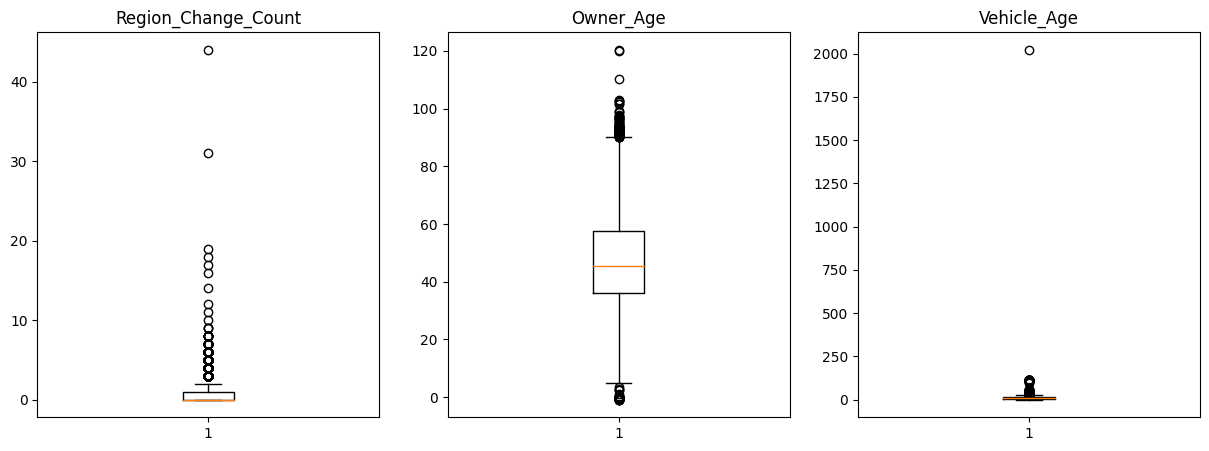

In [15]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.boxplot(data['Region_Change_Count'])
plt.title("Region_Change_Count")

plt.subplot(1, 3, 2)
plt.boxplot(data['Owner_Age'])
plt.title("Owner_Age")

plt.subplot(1, 3, 3)
plt.boxplot(data['Vehicle_Age'])
plt.title("Vehicle_Age");

> Кол-во раз смены региона колеблется от 0 до более чем 40 раз.

> Возраст владельца ТС может быть как отрицательным, нулевым, так и больше 120 лет.

> Возраст ТС принимает значения от -1 до 2000 лет.

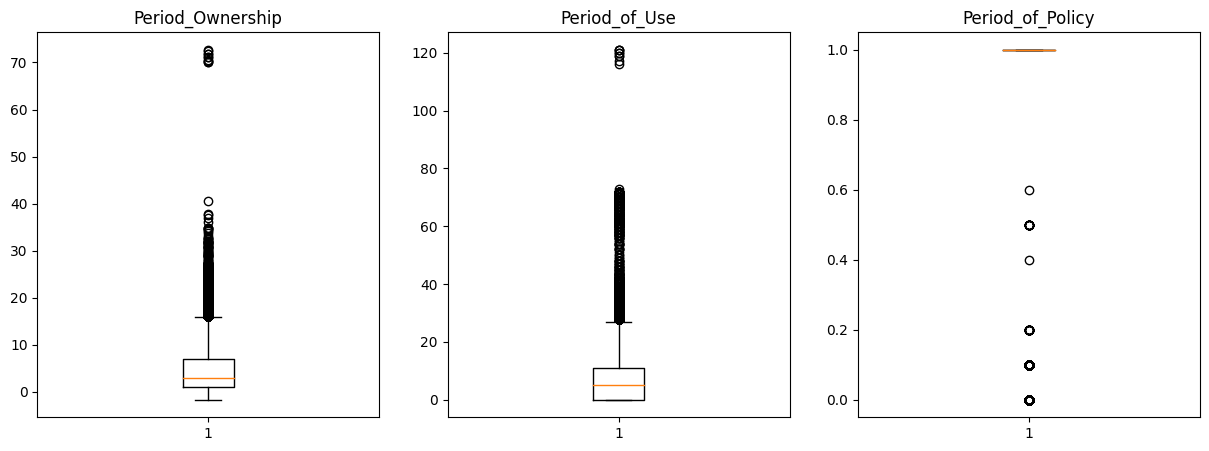

In [16]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.boxplot(data['Period_Ownership'])
plt.title("Period_Ownership")

plt.subplot(1, 3, 2)
plt.boxplot(data['Period_of_Use'])
plt.title("Period_of_Use")

plt.subplot(1, 3, 3)
plt.boxplot(data['Period_of_Policy'])
plt.title("Period_of_Policy");

> Период владения ТС может быть как отрицательным, так и более 70 лет.

> Период использования ТС принимает значения от 0 до 120 лет.

> Срок действия полиса принимает значения от 0 дней до 1 года.

#### Давайте проверим записи с потенциальными выбросами - может быть в них присутствует целевой признак.

In [17]:
data[((data['Vehicle_EngineHPower'] > 1000) | (data['Period_Ownership'] > 40) | (data['Period_Ownership'] < 0) |
    (data['WP'] > 80000) | (data['WP'] <= 0) | (data['Allowed_Count'] > 20) | (data['Region_Change_Count'] > 10) | 
    (data['Owner_Age'] > 100) | (data['Owner_Age'] < 18) | (data['Vehicle_Age'] > 60) | (data['Vehicle_Age'] < 0) | 
    (data['Period_of_Use'] > 80) | (data['Vehicle_EngineHPower'] == 0))]['Flag_Guilty'].value_counts()

0    5671
1     338
Name: Flag_Guilty, dtype: int64

> Видим, что потенциальных выбросов чуть больше 5500 и среди них содержится только 338 целевых признаков. Удалим эти выбросы.

#### Удаляем выбросы.

In [18]:
data_cleaned = data[(data['Vehicle_EngineHPower'] > 0) & (data['Vehicle_EngineHPower'] <= 1000) &
                    (data['WP'] > 0) & (data['WP'] <= 80000) & (data['Allowed_Count'] <= 20) &
                    (data['Period_Ownership'] <= 40) & (data['Period_Ownership'] >= 0) &
                    (data['Owner_Age'] <= 100) & (data['Owner_Age'] >= 18) &
                    (data['Vehicle_Age'] <= 60) & (data['Vehicle_Age'] >= 0) &
                    (data['Period_of_Use'] <= 80) & (data['Region_Change_Count'] <= 10)]

data_cleaned.reset_index(drop=True, inplace=True)
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 493989 entries, 0 to 493988
Data columns (total 17 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Vehicle_Brand         493989 non-null  object 
 1   Vehicle_Category      493989 non-null  object 
 2   Vehicle_EngineHPower  493989 non-null  float32
 3   Vehicle_Usage         493989 non-null  object 
 4   Vehicle_Region_ID     493989 non-null  int64  
 5   Transit_Flag          493989 non-null  int64  
 6   WP                    493989 non-null  float32
 7   Allowed_Count         493989 non-null  int64  
 8   KBM_ID                493989 non-null  int64  
 9   Region_Change_Count   493989 non-null  int64  
 10  Amount_Accidents      493989 non-null  int64  
 11  Flag_Guilty           493989 non-null  int64  
 12  Owner_Age             493989 non-null  float64
 13  Vehicle_Age           493989 non-null  int64  
 14  Period_Ownership      493989 non-null  float64
 15  

In [19]:
data_cleaned.describe()

,Vehicle_EngineHPower,Vehicle_Region_ID,Transit_Flag,WP,Allowed_Count,KBM_ID,Region_Change_Count,Amount_Accidents,Flag_Guilty,Owner_Age,Vehicle_Age,Period_Ownership,Period_of_Use,Period_of_Policy
count,493989.000000,493989.000000,493989.000000,493989.000000,493989.000000,493989.000000,493989.00000,493989.000000,493989.000000,493989.000000,493989.000000,493989.000000,493989.000000,493989.000000
mean,122.572479,48.274982,0.003235,5977.450195,1.738059,10.281235,0.34951,0.043626,0.039558,46.949038,11.089739,4.389818,6.518396,0.996821
std,50.830585,23.281395,0.056784,3954.047852,0.932738,3.438953,0.69364,0.227828,0.194918,13.599497,6.840134,4.170709,6.959281,0.053581
min,1.000000,1.000000,0.000000,0.010000,0.000000,1.000000,0.00000,0.000000,0.000000,18.000000,0.000000,-0.000000,0.000000,0.000000
25%,87.000000,27.000000,0.000000,3551.040039,1.000000,7.000000,0.00000,0.000000,0.000000,36.100000,6.000000,1.000000,0.000000,1.000000
50%,110.000000,50.000000,0.000000,5013.129883,2.000000,10.000000,0.00000,0.000000,0.000000,45.500000,10.000000,3.000000,5.000000,1.000000
75%,143.000000,68.000000,0.000000,7188.569824,2.000000,14.000000,1.00000,0.000000,0.000000,57.800000,15.000000,7.000000,11.000000,1.000000
max,1000.000000,94.000000,1.000000,77222.609375,20.000000,15.000000,9.00000,7.000000,1.000000,99.200000,54.000000,37.700000,72.000000,1.000000


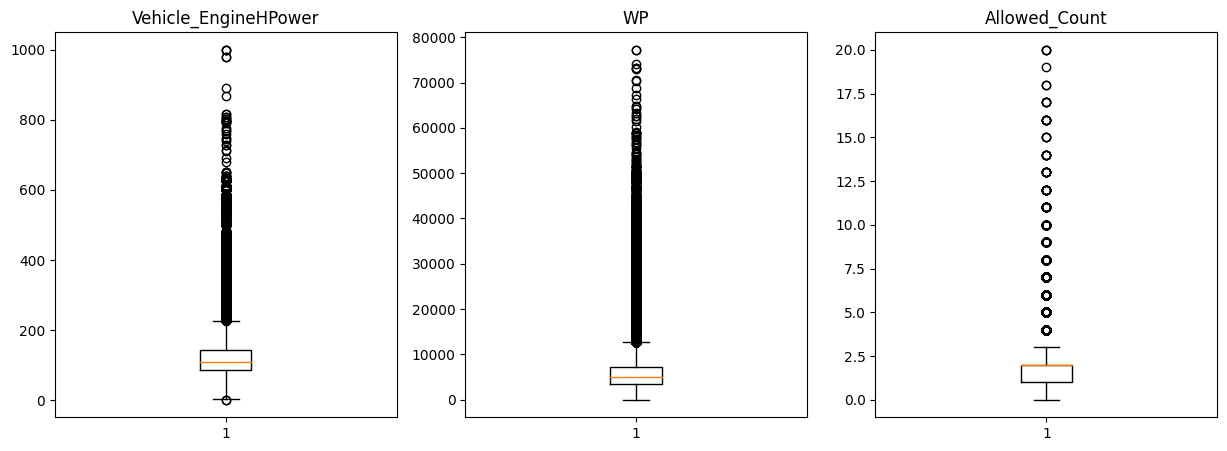

In [20]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.boxplot(data_cleaned['Vehicle_EngineHPower'])
plt.title("Vehicle_EngineHPower")

plt.subplot(1, 3, 2)
plt.boxplot(data_cleaned['WP'])
plt.title("WP")

plt.subplot(1, 3, 3)
plt.boxplot(data_cleaned['Allowed_Count'])
plt.title("Allowed_Count");

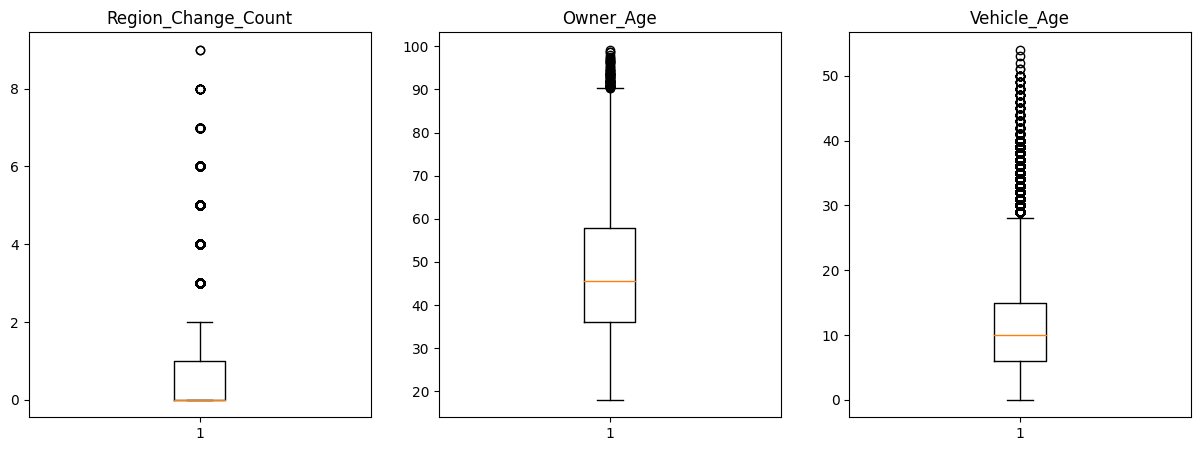

In [21]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.boxplot(data_cleaned['Region_Change_Count'])
plt.title("Region_Change_Count")

plt.subplot(1, 3, 2)
plt.boxplot(data_cleaned['Owner_Age'])
plt.title("Owner_Age")

plt.subplot(1, 3, 3)
plt.boxplot(data_cleaned['Vehicle_Age'])
plt.title("Vehicle_Age");

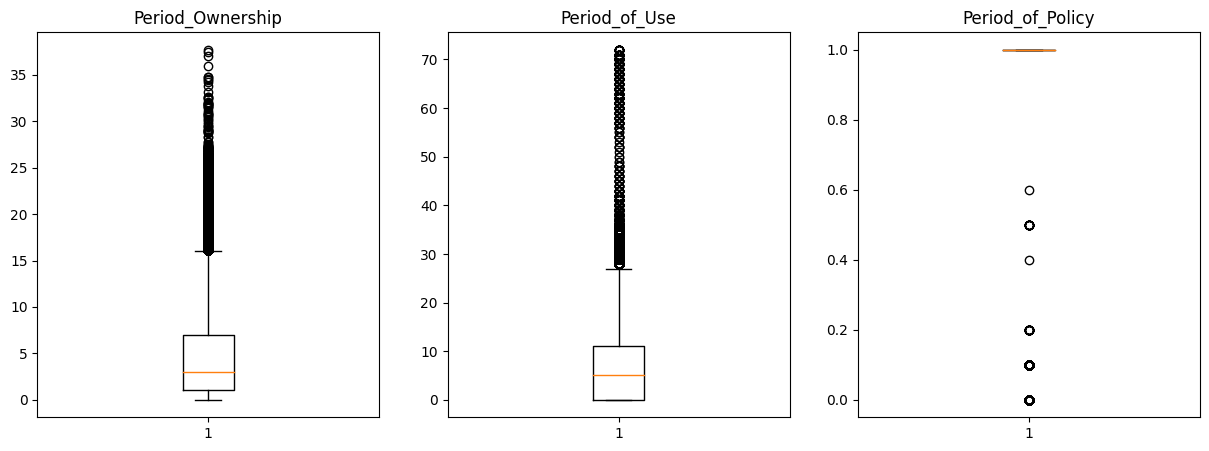

In [22]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.boxplot(data_cleaned['Period_Ownership'])
plt.title("Period_Ownership")

plt.subplot(1, 3, 2)
plt.boxplot(data_cleaned['Period_of_Use'])
plt.title("Period_of_Use")

plt.subplot(1, 3, 3)
plt.boxplot(data_cleaned['Period_of_Policy'])
plt.title("Period_of_Policy");

#### Посмотрим на целевую метрику

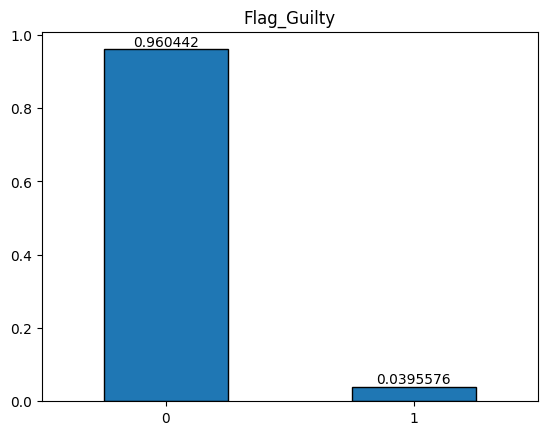

In [23]:
ax = data_cleaned.Flag_Guilty.value_counts(normalize=True).plot(kind='bar', title="Flag_Guilty", rot=0.5)
ax.bar_label(ax.containers[0]);

> Целевое значение = 1. По графику видно, что данные очень сильно не сбалансированы.

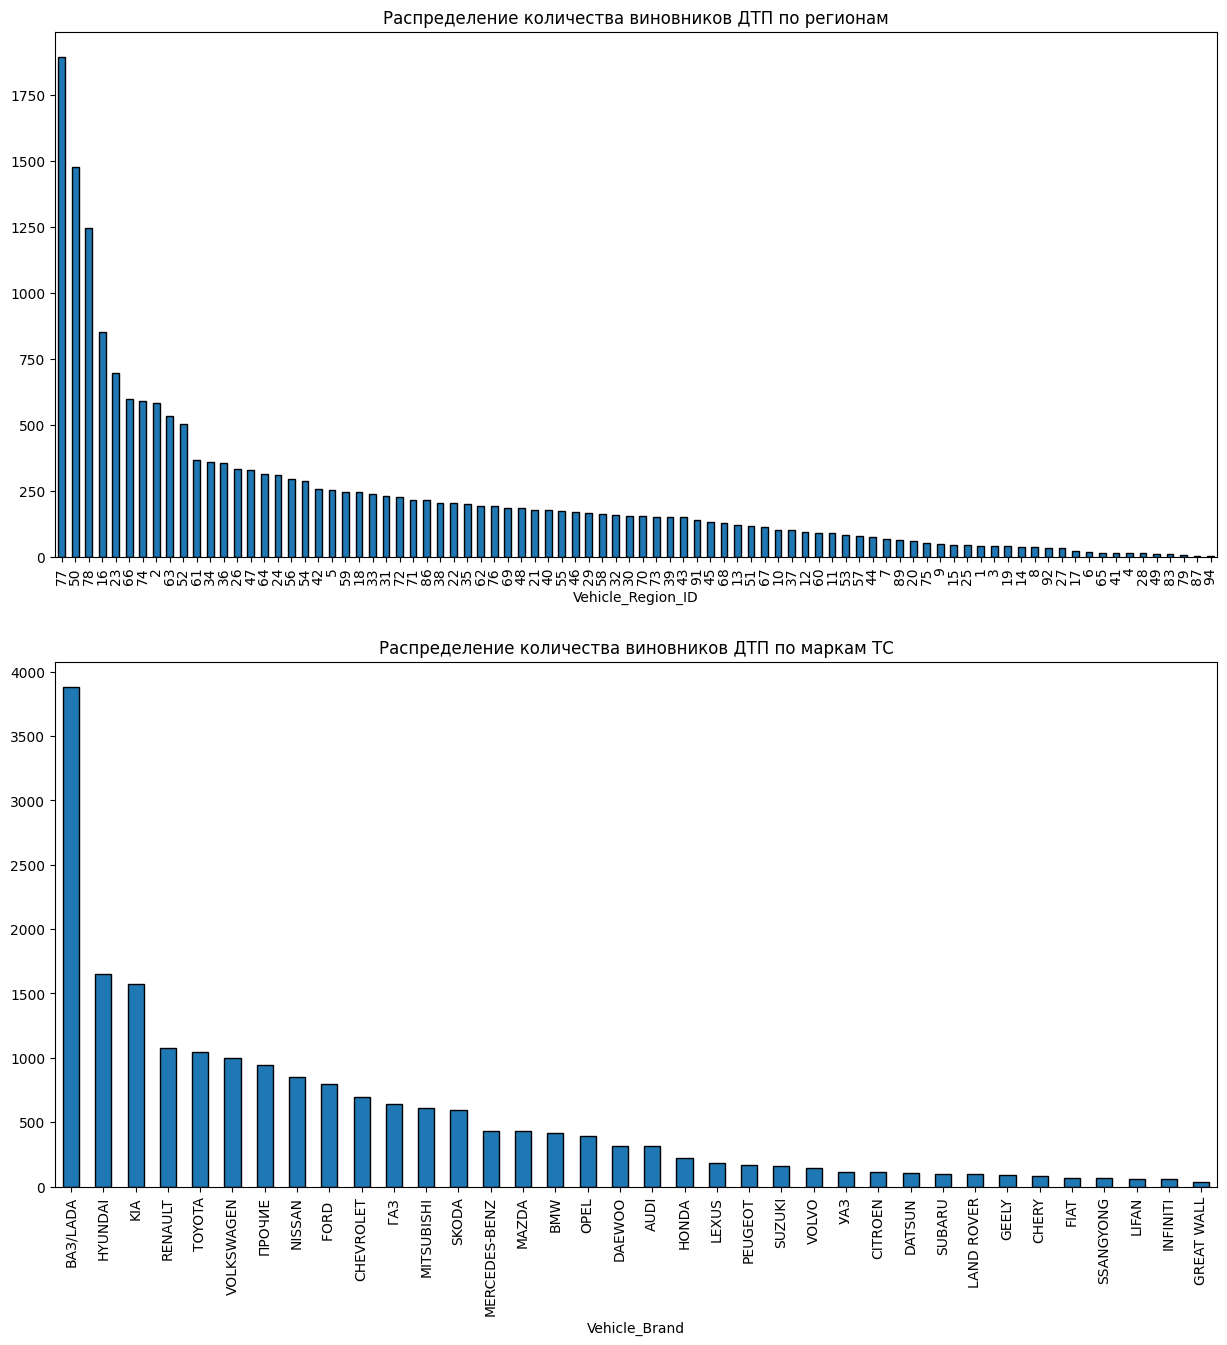

In [24]:
fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize = (15, 15))

data_cleaned.groupby(['Vehicle_Region_ID'])['Flag_Guilty'].sum().sort_values(ascending=False).plot(kind='bar',
                                                        title='Распределение количества виновников ДТП по регионам', ax=axes[0])

data_cleaned.groupby(['Vehicle_Brand'])['Flag_Guilty'].sum().sort_values(ascending=False).plot(kind='bar',
                                                    title='Распределение количества виновников ДТП по маркам ТС', ax=axes[1]);

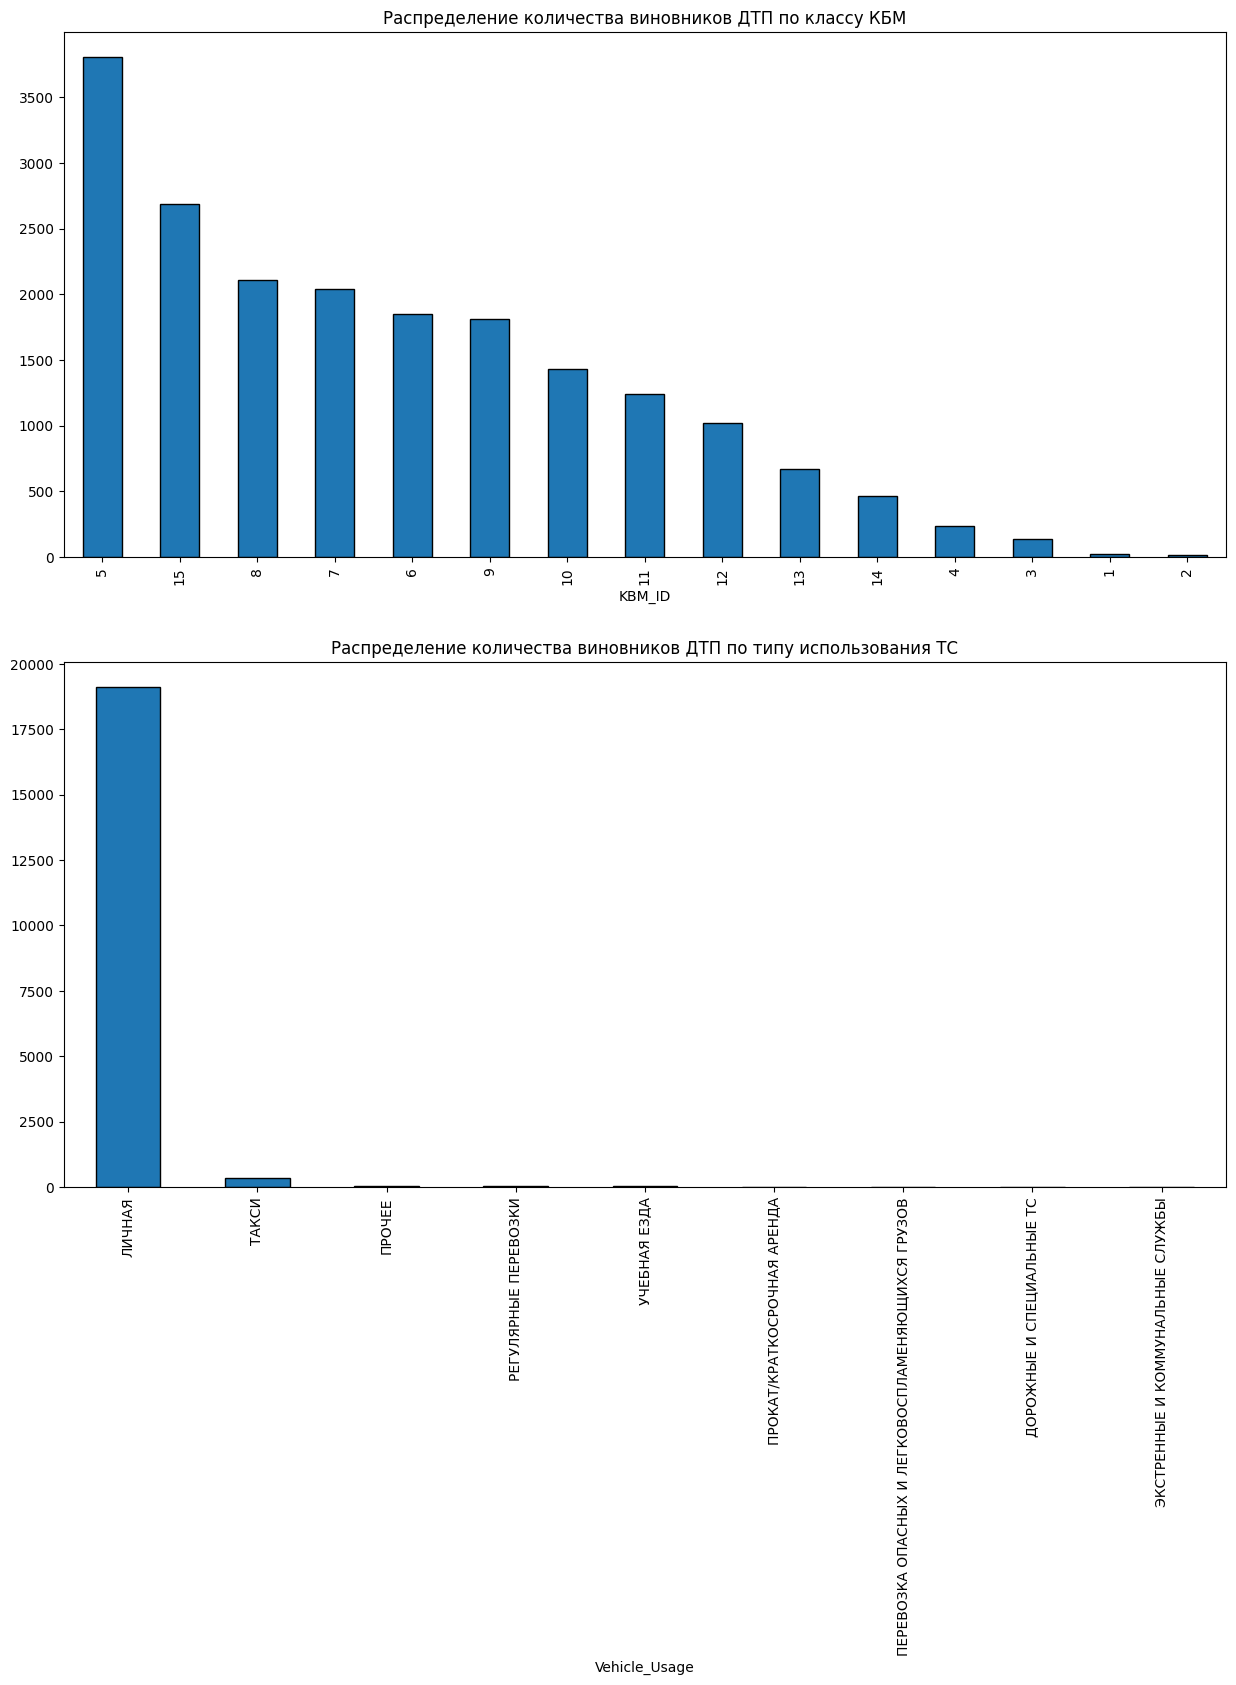

In [25]:
fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize = (15, 15))

data_cleaned.groupby(['KBM_ID'])['Flag_Guilty'].sum().sort_values(ascending=False).plot(kind='bar',
                                        title='Распределение количества виновников ДТП по классу КБМ', ax=axes[0])

data_cleaned.groupby(['Vehicle_Usage'])['Flag_Guilty'].sum().sort_values(ascending=False).plot(kind='bar',
                                        title='Распределение количества виновников ДТП по типу использования ТС', ax=axes[1]);

**Видим две очевидные картины:**
* в ТОП-3 регионов по кол-ву виновников ДТП входят Москва, Московская область и Санкт-Петербург.
* лидерами по кол-ву виновников ДТП являются автомобили марки ВАЗ, а также Hyundai и KIA.

> Последние две марки часто используются в такси, но по четвертому графику мы видим, что доля такси в распределении кол-ва виновников ДТП очень низкая - это может говорить о том, что таксисты часто становятся виновниками ДТП, но при этом в полисах не указывают на использование ТС в качестве такси. Это явный признак мошенничества.

* Также на третьем графике видно, что наибольшее кол-во виновников ДТП приходится на KBM_ID = 5, что соответствует 3-ему классу. Данный класс присваивается новичкам. Отсюда можно сделать предположение, что чаще всего виновниками ДТП являются водители, впервые севшие за руль.

#### Сгруппируем категориальные признаки:

In [26]:
def cat_hpower(x):
    if x <= 50:
        return('<=50')
    elif (x > 50) & (x <= 100):
        return('between 50 and 100')
    elif (x > 100) & (x <= 150):
        return('between 100 and 150')   
    elif (x > 150) & (x <= 200):
        return('between 150 and 200') 
    elif (x > 200) & (x <= 250):
        return('between 200 and 250') 
    else:
        return('>250')

def cat_wp(x):
    if x <= 10000:
        return('<=10000')
    elif (x > 10000) & (x <= 20000):
        return('between 10000 and 20000')
    elif (x > 20000) & (x <= 30000):
        return('between 20000 and 30000')   
    elif (x > 30000) & (x <= 40000):
        return('between 30000 and 40000') 
    elif (x > 40000) & (x <= 50000):
        return('between 40000 and 50000') 
    elif (x > 50000) & (x <= 60000):
        return('between 50000 and 60000') 
    elif (x > 60000) & (x <= 70000):
        return('between 60000 and 70000') 
    else:
        return('>70000')

def cat_vehicle_age(x):
    if x <= 5:
        return('<=5')
    elif (x > 5) & (x <= 10):
        return('between 5 and 10')
    elif (x > 10) & (x <= 15):
        return('between 10 and 15')   
    elif (x > 15) & (x <= 20):
        return('between 15 and 20') 
    elif (x > 20) & (x <= 25):
        return('between 20 and 25') 
    elif (x > 25) & (x <= 30):
        return('between 25 and 30') 
    elif (x > 30) & (x <= 35):
        return('between 30 and 35')
    elif (x > 35) & (x <= 40):
        return('between 35 and 40')   
    elif (x > 40) & (x <= 45):
        return('between 40 and 45') 
    elif (x > 45) & (x <= 50):
        return('between 45 and 50') 
    else:
        return('>50')

def cat_owner_age(x):
    if x <= 30:
        return('<=30')
    elif (x > 30) & (x <= 40):
        return('between 30 and 40')
    elif (x > 40) & (x <= 50):
        return('between 40 and 50')   
    elif (x > 50) & (x <= 60):
        return('between 50 and 60') 
    elif (x > 60) & (x <= 70):
        return('between 60 and 70') 
    elif (x > 70) & (x <= 80):
        return('between 70 and 80') 
    else:
        return('>80')

def cat_period_use(x):
    if x <= 5:
        return('<=5')
    elif (x > 5) & (x <= 10):
        return('between 5 and 10')
    elif (x > 10) & (x <= 15):
        return('between 10 and 15')   
    elif (x > 15) & (x <= 20):
        return('between 15 and 20') 
    elif (x > 20) & (x <= 25):
        return('between 20 and 25') 
    elif (x > 25) & (x <= 30):
        return('between 25 and 30') 
    elif (x > 30) & (x <= 35):
        return('between 30 and 35')
    elif (x > 35) & (x <= 40):
        return('between 35 and 40')   
    elif (x > 40) & (x <= 45):
        return('between 40 and 45') 
    elif (x > 45) & (x <= 50):
        return('between 45 and 50') 
    else:
        return('>50')

def cat_period_ownership(x):
    if x <= 5:
        return('<=5')
    elif (x > 5) & (x <= 10):
        return('between 5 and 10')
    elif (x > 10) & (x <= 15):
        return('between 10 and 15')   
    elif (x > 15) & (x <= 20):
        return('between 15 and 20') 
    elif (x > 20) & (x <= 25):
        return('between 20 and 25') 
    elif (x > 25) & (x <= 30):
        return('between 25 and 30') 
    else:
        return('>30')
    
data_cleaned['Vehicle_EngineHPower_Cat'] = data_cleaned['Vehicle_EngineHPower'].apply(cat_hpower)
data_cleaned['WP_Cat'] = data_cleaned['WP'].apply(cat_wp)
data_cleaned['Vehicle_Age_Cat'] = data_cleaned['Vehicle_Age'].apply(cat_vehicle_age)
data_cleaned['Owner_Age_Cat'] = data_cleaned['Owner_Age'].apply(cat_owner_age)
data_cleaned['Period_of_Use_Cat'] = data_cleaned['Period_of_Use'].apply(cat_period_use)
data_cleaned['Period_Ownership_Cat'] = data_cleaned['Period_Ownership'].apply(cat_period_ownership)

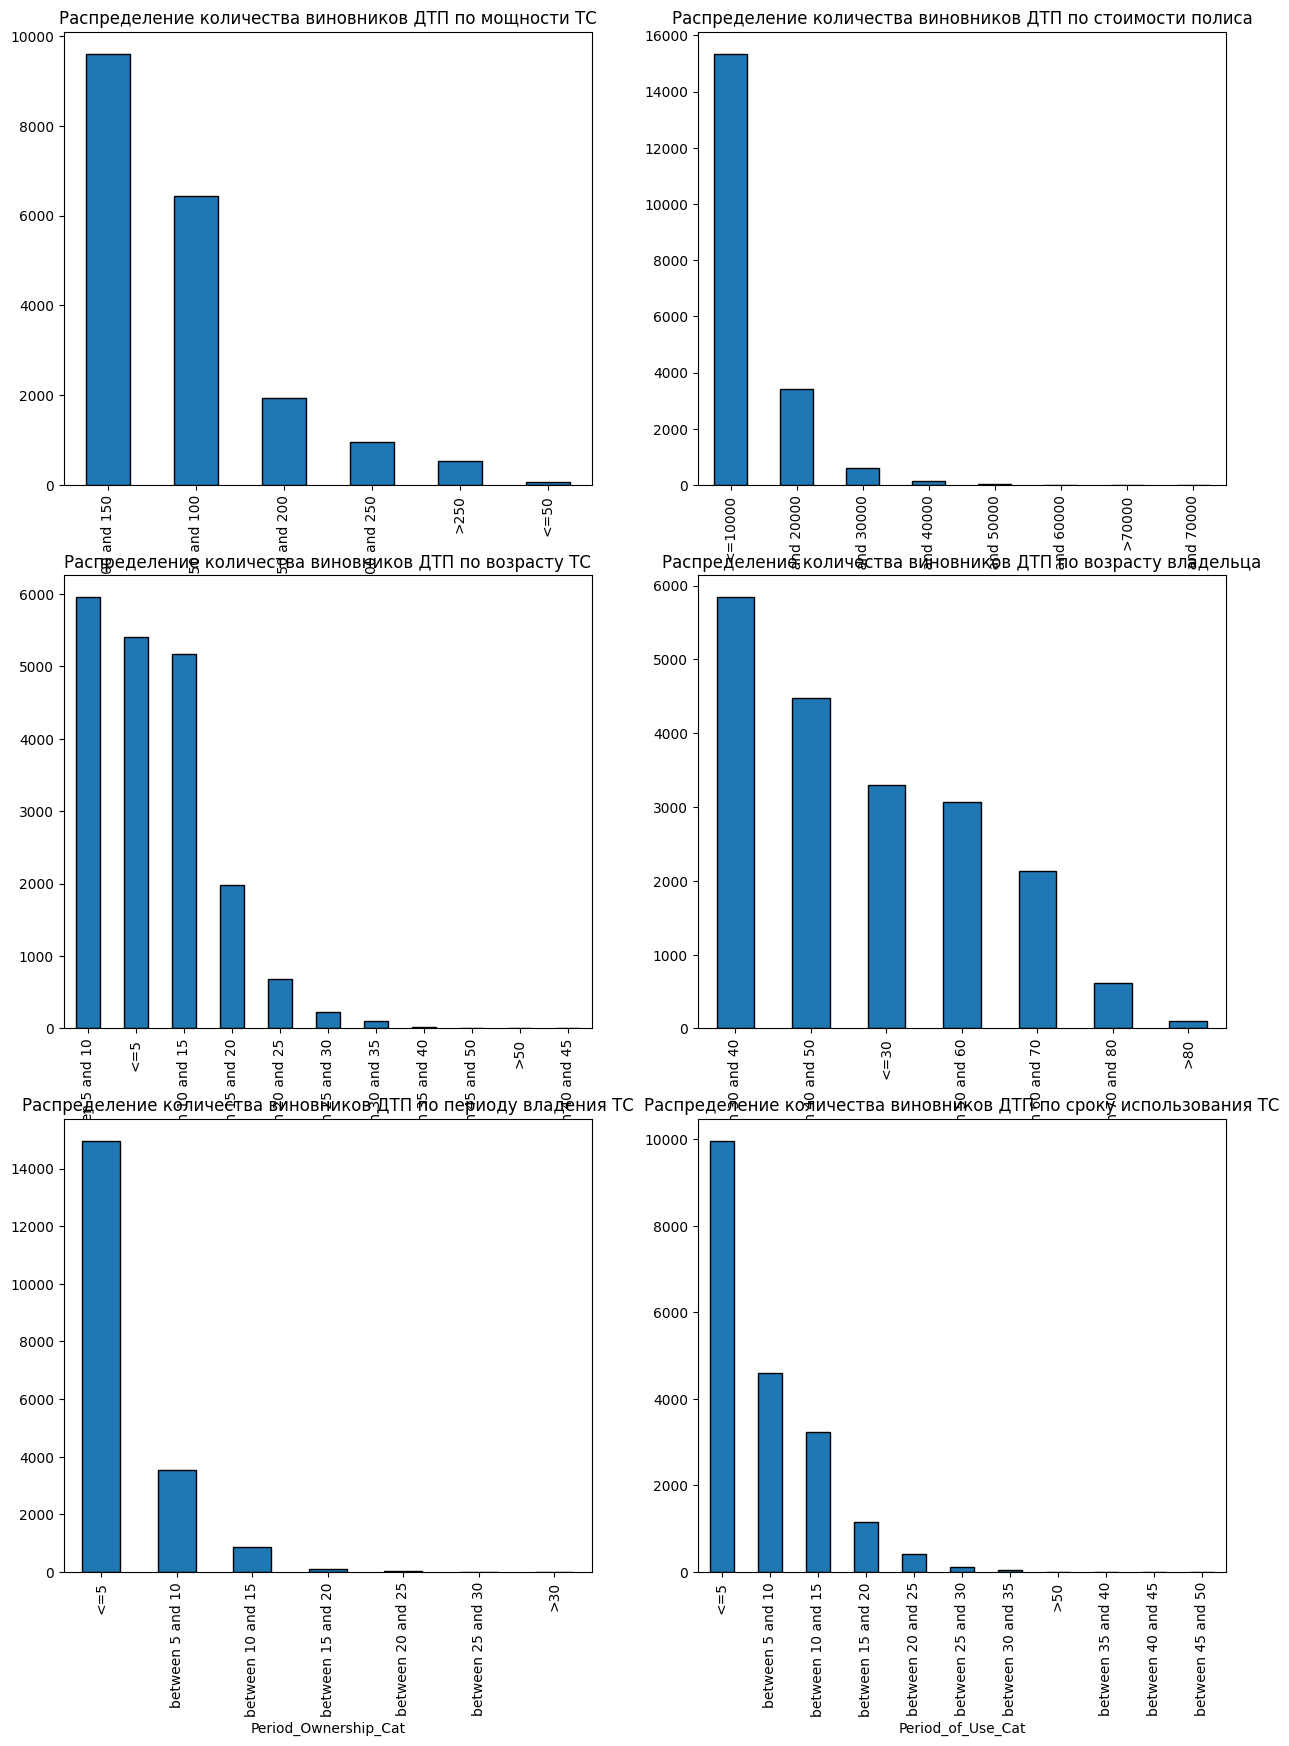

In [27]:
fig, axes = plt.subplots(nrows = 3, ncols = 2, figsize = (15, 20))

data_cleaned.groupby(['Vehicle_EngineHPower_Cat'])['Flag_Guilty'].sum().sort_values(ascending=False).plot(kind='bar',
                                        title='Распределение количества виновников ДТП по мощности ТС', ax=axes[0][0])

data_cleaned.groupby(['WP_Cat'])['Flag_Guilty'].sum().sort_values(ascending=False).plot(kind='bar',
                                        title='Распределение количества виновников ДТП по стоимости полиса', ax=axes[0][1])

data_cleaned.groupby(['Vehicle_Age_Cat'])['Flag_Guilty'].sum().sort_values(ascending=False).plot(kind='bar',
                                        title='Распределение количества виновников ДТП по возрасту ТС', ax=axes[1][0])

data_cleaned.groupby(['Owner_Age_Cat'])['Flag_Guilty'].sum().sort_values(ascending=False).plot(kind='bar',
                                        title='Распределение количества виновников ДТП по возрасту владельца', ax=axes[1][1])

data_cleaned.groupby(['Period_Ownership_Cat'])['Flag_Guilty'].sum().sort_values(ascending=False).plot(kind='bar',
                                    title='Распределение количества виновников ДТП по периоду владения ТС', ax=axes[2][0])

data_cleaned.groupby(['Period_of_Use_Cat'])['Flag_Guilty'].sum().sort_values(ascending=False).plot(kind='bar',
                                    title='Распределение количества виновников ДТП по сроку использования ТС', ax=axes[2][1]);

**По графикам видно следующее:**
* чаще всего в ДТП попадают машины с мощностью двигателя от 100 до 150 ЛС
* чаще всего виновниками ДТП являются ТС возрастом от 5 до 10 лет
* чаще всего виновниками ДТП выступают владельцы ТС в возрасте от 30 до 40 лет
* чаще всего виновниками ДТП являются ТС, которые находятся в эксплуатации менее 5 лет

> выводы 2 и 4 говорят о том, что виновниками становятся ТС, которые находятся в собственности у второго владельца

#### Построим матрицу корреляций:

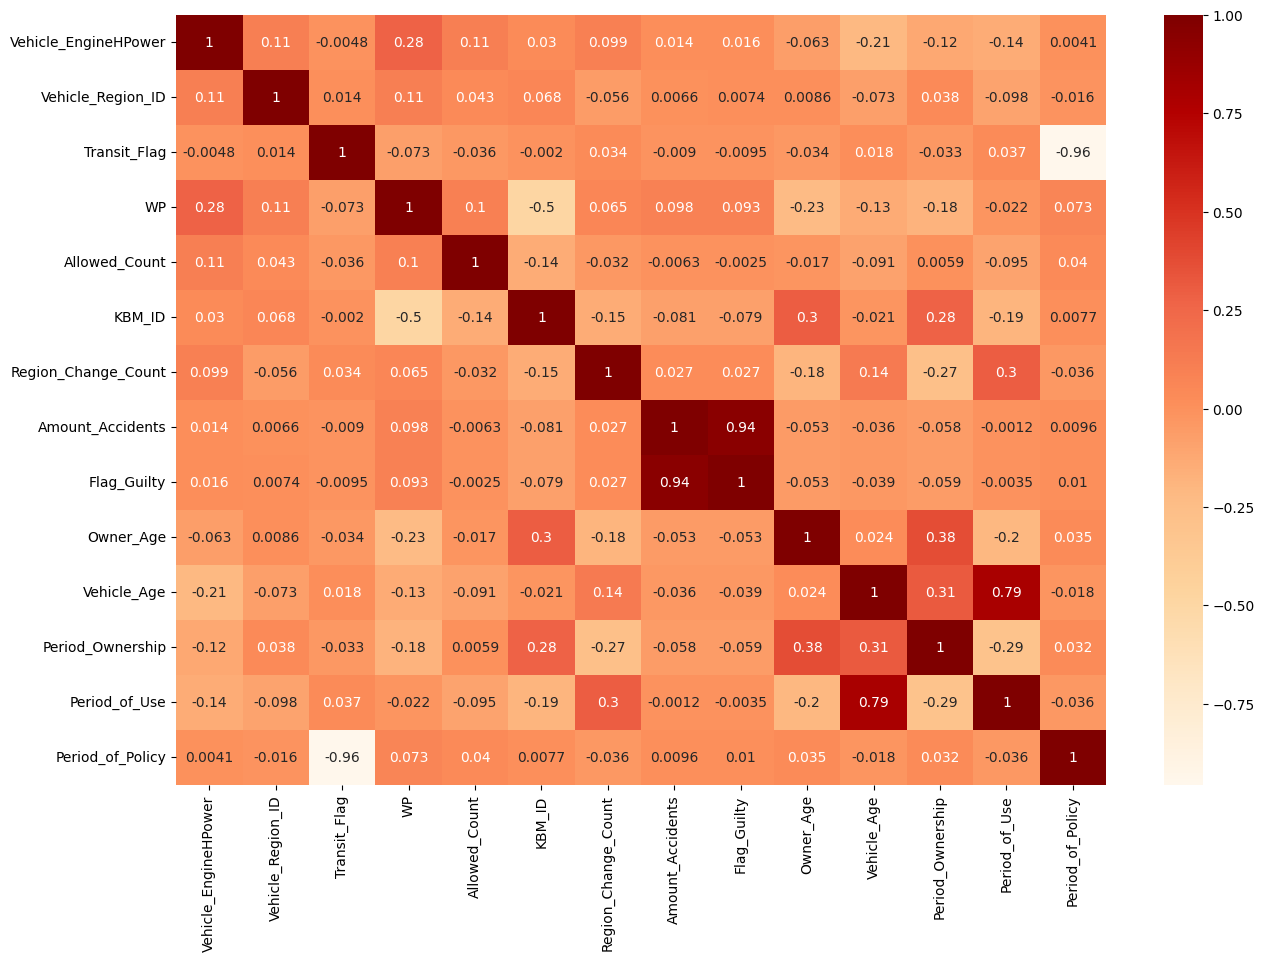

In [28]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(data_cleaned.drop(['Vehicle_EngineHPower_Cat', 'WP_Cat', 'Vehicle_Age_Cat',
                              'Owner_Age_Cat', 'Period_Ownership_Cat', 'Period_of_Use_Cat'], axis=1).corr(), 
            annot=True, cmap='OrRd');

> Видим, что срок действия полиса сильно коррелирует с флагом о транзитности ТС, а также кол-во ДТП с целевым признаком (что очевидно). Поэтому можно удалить два этих показателя - Transit_Flag и Amount_Accidents. Также сильная взаимосвязь наблюдается между периодом использования ТС и возрастом ТС - удалим показатель Period_of_Use.

#### Применим для начала метод логистической регрессии

In [29]:
data_cleaned_logreg = pd.get_dummies(data_cleaned.drop(['Amount_Accidents', 'Transit_Flag', 'Period_of_Use', 
                                                     'Vehicle_EngineHPower_Cat', 'WP_Cat', 'Vehicle_Age_Cat',
                                                     'Owner_Age_Cat', 'Period_Ownership_Cat', 'Period_of_Use_Cat'], axis=1))
data_cleaned_logreg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 493989 entries, 0 to 493988
Data columns (total 61 columns):
 #   Column                                                          Non-Null Count   Dtype  
---  ------                                                          --------------   -----  
 0   Vehicle_EngineHPower                                            493989 non-null  float32
 1   Vehicle_Region_ID                                               493989 non-null  int64  
 2   WP                                                              493989 non-null  float32
 3   Allowed_Count                                                   493989 non-null  int64  
 4   KBM_ID                                                          493989 non-null  int64  
 5   Region_Change_Count                                             493989 non-null  int64  
 6   Flag_Guilty                                                     493989 non-null  int64  
 7   Owner_Age                             

#### Разделим набор данных на матрицу наблюдений X и столбец ответов y:

In [134]:
X = data_cleaned_logreg.drop("Flag_Guilty", axis=1)
y = data_cleaned_logreg["Flag_Guilty"]

#### Целевая метрика - F-мера, поэтому для начала найдем пороговое значение для нее:

Лучший порог = 0.0697, F1-Score = 0.1379


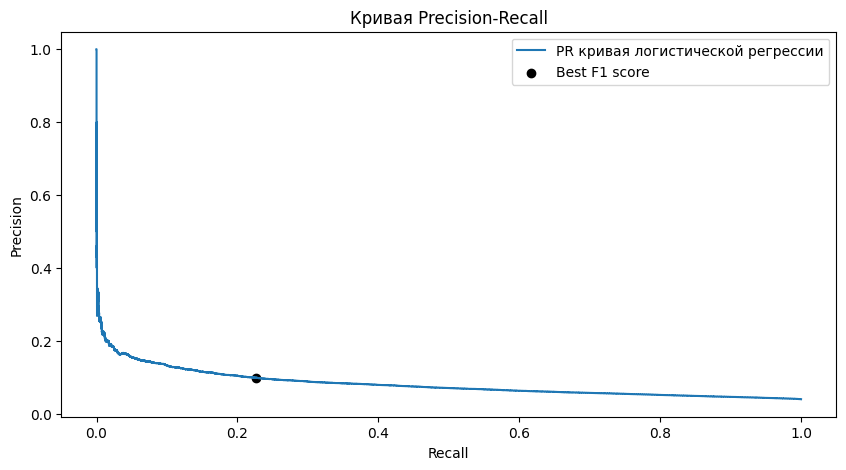

In [42]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, random_state=42)

#Применим стандартизацию данных
mm_scaler = preprocessing.MinMaxScaler()
mm_scaler.fit(X_train)

X_train_scaled = mm_scaler.transform(X_train)
X_test_scaled = mm_scaler.transform(X_test)

log_reg = linear_model.LogisticRegression(solver='sag', random_state=42, max_iter=1000)

#Используем стратификацию с 10 фолдами
skf = model_selection.StratifiedKFold(n_splits=10)


#Делаем предсказание вероятностей на кросс-валидации
y_cv_proba_pred = model_selection.cross_val_predict(log_reg, X_train_scaled, y_train, cv=skf, method='predict_proba')

#Выделяем столбец с вероятностями для класса 1 
y_cv_proba_pred = y_cv_proba_pred[:, 1]

#Вычисляем координаты PR-кривой
precision, recall, thresholds = metrics.precision_recall_curve(y_train, y_cv_proba_pred)

#Вычисляем F1-меру при различных threshold
f1_scores = (2 * precision * recall) / (precision + recall)
#Определяем индекс максимума
idx = np.argmax(f1_scores)
print('Лучший порог = {:.4f}, F1-Score = {:.4f}'.format(thresholds[idx], f1_scores[idx]))

#Строим PR-кривую
fig, ax = plt.subplots(figsize=(10, 5))
#Строим линейный график зависимости precision от recall
ax.plot(recall, precision, label='PR кривая логистической регрессии')
#Отмечаем точку максимума F1
ax.scatter(recall[idx], precision[idx], marker='o', color='black', label='Best F1 score')
#Даем графику название и подписи осям
ax.set_title('Кривая Precision-Recall')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
#Отображаем легенду
ax.legend();

> Видим, что лучшее пороговое значение составляет 0.07, что довольно низко, чем стандартное 0.5. Но при таком пороге значение F1-меры будет наилучшее, поэтому возьмем его.

In [50]:
#Задаём оптимальный порог вероятностей
threshold_opt = 0.07

#Объекты, для которых вероятность быть классом 1 > threshold_opt, относим к классу 1
#В противном случае — к классу 0
y_test_pred_proba = log_reg.fit(X_train_scaled, y_train).predict_proba(X_test_scaled)[:, 1]
y_test_pred = (y_test_pred_proba > threshold_opt).astype('int')

print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.97      0.92      0.94    118692
           1       0.10      0.22      0.13      4806

    accuracy                           0.89    123498
   macro avg       0.53      0.57      0.54    123498
weighted avg       0.93      0.89      0.91    123498



> Мы видим, что значение F-меры составляет всего 13%, что довольно низкий результат. Попробуем его улучшить другими методами.

In [69]:
# Также можем посмотреть значение метрики ROC_AUC
metrics.roc_auc_score(y_test, y_test_pred)

0.5686147074270598

> Видим, что значение AUC приближено к 0.5. Это означает, что такая модель не обладает предсказательной силой и делает предсказания в случайном порядке.

In [ ]:
# cv_metrics = model_selection.cross_validate(
#     estimator=log_reg,
#     X=X_train_scaled,
#     y=y_train,
#     cv=skf,
#     scoring='f1',
#     return_train_score=True
# )

# print('Среднее значение F-меры на тренировочной выборке: {:.5f}'.format(np.mean(cv_metrics['train_score'])))
# print('Среднее значение F-меры на валидационной выборке: {:.5f}'.format(np.mean(cv_metrics['test_score'])))

# print(f'Доля таргета в тренировочной выборке: {y_train.value_counts(normalize=True)[1].round(6)}')
# print(f'Доля таргета в тестовой выборке: {y_test.value_counts(normalize=True)[1].round(6)}')

#### Применим алгоритм случайного леса

In [108]:
#Для начала найдем гиперпараметры для случайного леса
param_distributions = {'n_estimators': list(range(50, 200, 30)),
                       'min_samples_leaf': list(range(2, 11, 1)),
                       'max_depth': list(range(10, 25, 1)),
                       'criterion':['entropy','gini','log_loss']
                      } 

random_search_forest = model_selection.RandomizedSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_distributions=param_distributions, 
    cv=skf,
    n_iter = 150, 
    n_jobs = -1
)

random_search_forest.fit(X_train_scaled, y_train)
print("Наилучшие значения гиперпараметров: {}".format(random_search_forest.best_params_))

Наилучшие значения гиперпараметров: {'n_estimators': 110, 'min_samples_leaf': 6, 'max_depth': 19, 'criterion': 'gini'}


Лучший порог = 0.0736, F1-Score = 0.1446


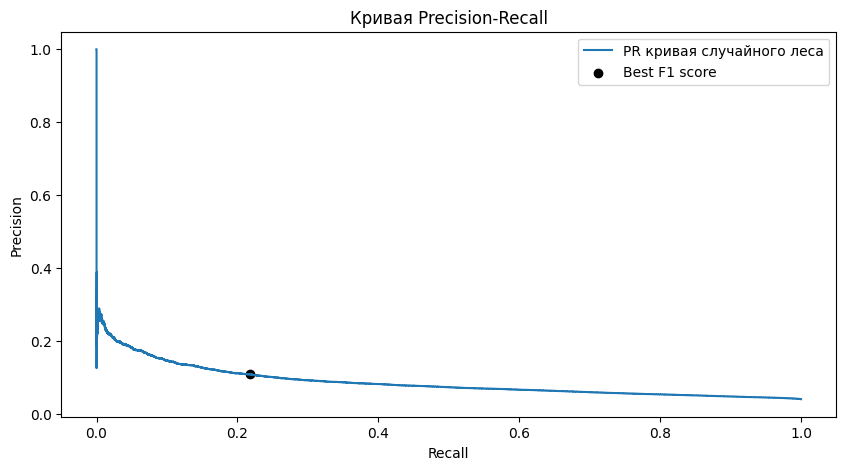

In [109]:
#С помощью найденных гиперпараметров снова определим порог F-меры
randomforest = ensemble.RandomForestClassifier(n_estimators = random_search_forest.best_params_['n_estimators'],
                                               min_samples_leaf = random_search_forest.best_params_['min_samples_leaf'],
                                               max_depth = random_search_forest.best_params_['max_depth'], 
                                               criterion = random_search_forest.best_params_['criterion'], random_state=42)

#Делаем предсказание вероятностей на кросс-валидации
y_cv_proba_pred = model_selection.cross_val_predict(randomforest, X_train_scaled, y_train, cv=skf, method='predict_proba')

#Выделяем столбец с вероятностями для класса 1 
y_cv_proba_pred = y_cv_proba_pred[:, 1]

#Вычисляем координаты PR-кривой
precision, recall, thresholds = metrics.precision_recall_curve(y_train, y_cv_proba_pred)

#Вычисляем F1-меру при различных threshold
f1_scores = (2 * precision * recall) / (precision + recall)
#Определяем индекс максимума
idx = np.argmax(f1_scores)
print('Лучший порог = {:.4f}, F1-Score = {:.4f}'.format(thresholds[idx], f1_scores[idx]))

#Строим PR-кривую
fig, ax = plt.subplots(figsize=(10, 5))
#Строим линейный график зависимости precision от recall
ax.plot(recall, precision, label='PR кривая случайного леса')
#Отмечаем точку максимума F1
ax.scatter(recall[idx], precision[idx], marker='o', color='black', label='Best F1 score')
#Даем графику название и подписи осям
ax.set_title('Кривая Precision-Recall')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
#Отображаем легенду
ax.legend();

> Видим, что пороговое значение вероятностей практически не изменилось и составляет 0.07

In [112]:
#Задаём оптимальный порог вероятностей
threshold_opt = 0.07

y_test_pred_proba = randomforest.fit(X_train_scaled, y_train).predict_proba(X_test_scaled)[:, 1]
y_test_pred = (y_test_pred_proba > threshold_opt).astype('int')

print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.97      0.91      0.94    118692
           1       0.10      0.23      0.14      4806

    accuracy                           0.89    123498
   macro avg       0.53      0.57      0.54    123498
weighted avg       0.93      0.89      0.91    123498



> Результат стал лучше, но всего на 0.01. Теперь значение f-меры составляет 0.14.

In [116]:
# Также можем посмотреть значение метрики ROC_AUC
metrics.roc_auc_score(y_test, y_test_pred)

0.5716959521707966

#### Построим диаграмму коэффициентов значимости каждого из факторов

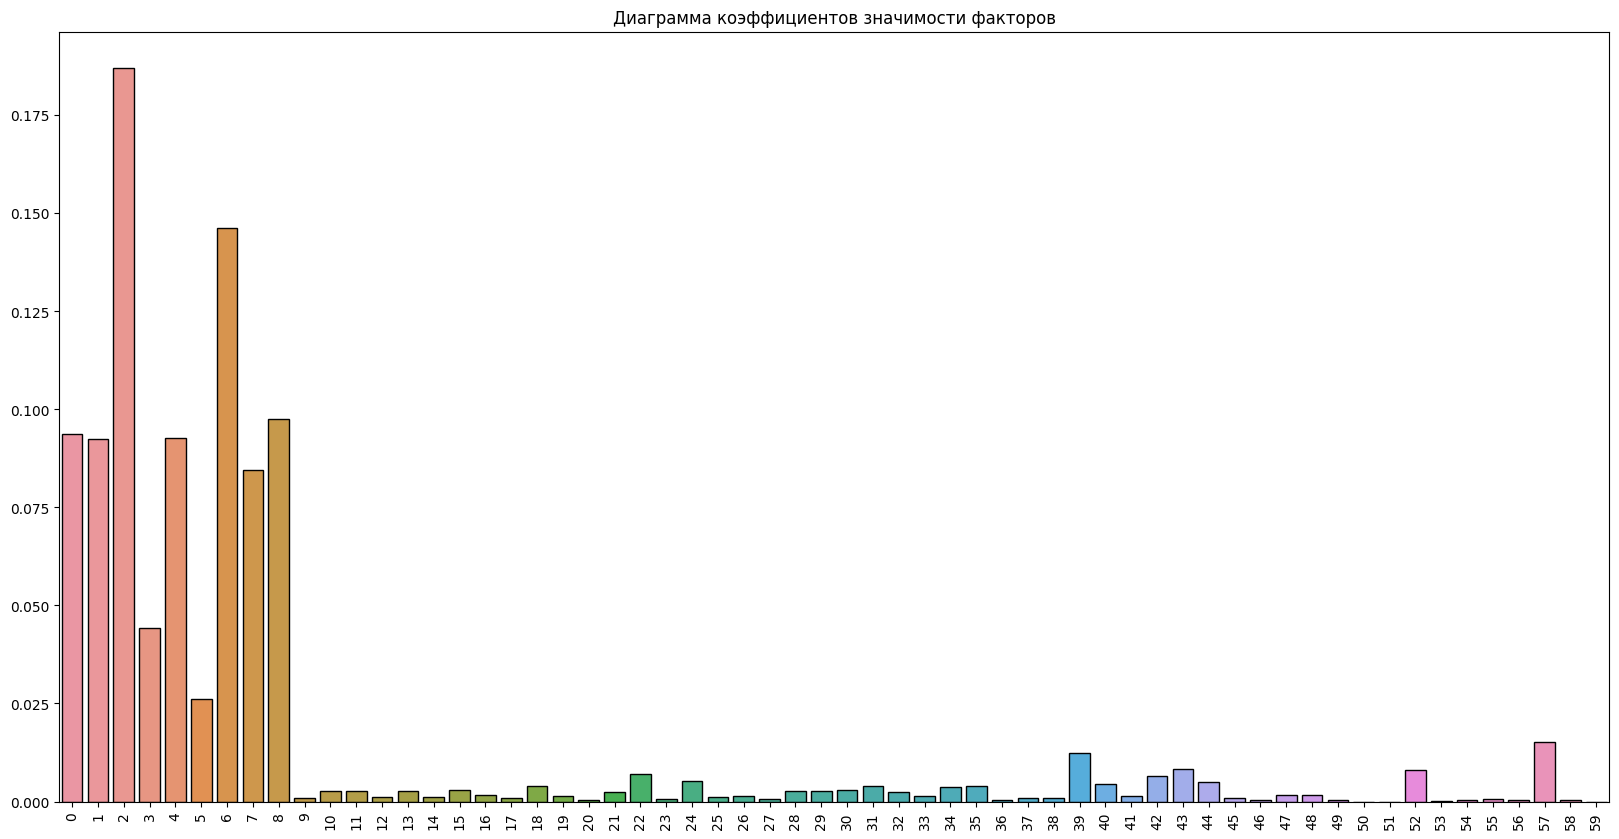

In [140]:
coef = randomforest.feature_importances_
data = pd.DataFrame([coef])
data

fig = plt.figure(figsize=(20, 10))
barplot = sns.barplot(data = data)
barplot.set_title('Диаграмма коэффициентов значимости факторов')
barplot.set_xticklabels(barplot.get_xticklabels(), rotation = 90);

> Видим, что наиболее значимым признаком является стоимость полиса, также вторым значимым признаком является возраст владельца авто.

## Вывод

Модель случайного леса показала незначительно лучше результат, чем модель логистической регрессии. Однако результаты обеих моделей очень низкие. Скорее всего это из-за нестабильности выборки, но она такая, т.к. доля ДТП сама по себе очень низкая, а виновников ДТП в них обычно не больше половины. Поэтому, к сожалению, на данном этапе получается только такой результат.

#### Попробуем произвести подготовку модели к продакшену и деплою

In [179]:
import pickle

# Производим сериализацию обученной модели
model = pickle.dumps(randomforest)

print(type(model))
print(type(randomforest))

<class 'bytes'>
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


In [181]:
# Производим сериализацию и записываем результат в файл формата pkl
with open('mymodel.pkl', 'wb') as output:
    pickle.dump(randomforest, output)